<a href="https://colab.research.google.com/github/SS-yong/Manufacturing_Data_Analysis/blob/main/%EC%82%AC%EC%B6%9C%EC%84%B1%ED%98%95_%EC%98%88%EC%A7%80%EB%B3%B4%EC%A0%84_AI_%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/DSS/DATA')

In [ ]:
data = pd.read_csv('InjectionMolding_Raw_Data.csv')

In [ ]:
data.columns

Index(['No_Shot', 'Machine_Cycle_Time', 'Cycle_Time', 'Barrel_Temp_Z1',
       'Barrel_Temp_Z2', 'Barrel_Temp_Z3', 'Barrel_Temp_Z4', 'Hopper_Temp',
       'Injection_Pressure_Real_Time', 'Screw_Position',
       'Injection_Peak_Press', 'Max_Injection_Rate', 'Screw_Velocity',
       'VP_Time', 'VP_Position', 'Weighing_Start_Position', 'VP_Press',
       'Plasticizing_Time', 'Plasticizing_Start_Position',
       'Plasticizing_End_Position', 'Plasticizing_RPM', 'Minimum_Cushion',
       'Cooling_Time', 'Back_Flow', 'Decompression_Time', '_ID'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030635 entries, 0 to 1030634
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   No_Shot                       1030635 non-null  int64  
 1   Machine_Cycle_Time            1030635 non-null  float64
 2   Cycle_Time                    1030635 non-null  float64
 3   Barrel_Temp_Z1                1030635 non-null  float64
 4   Barrel_Temp_Z2                1030635 non-null  float64
 5   Barrel_Temp_Z3                1030635 non-null  float64
 6   Barrel_Temp_Z4                1030635 non-null  float64
 7   Hopper_Temp                   1030635 non-null  float64
 8   Injection_Pressure_Real_Time  1030635 non-null  float64
 9   Screw_Position                1030635 non-null  float64
 10  Injection_Peak_Press          1030635 non-null  float64
 11  Max_Injection_Rate            1030635 non-null  float64
 12  Screw_Velocity              

In [ ]:
data.count()

No_Shot                         1030635
Machine_Cycle_Time              1030635
Cycle_Time                      1030635
Barrel_Temp_Z1                  1030635
Barrel_Temp_Z2                  1030635
Barrel_Temp_Z3                  1030635
Barrel_Temp_Z4                  1030635
Hopper_Temp                     1030635
Injection_Pressure_Real_Time    1030635
Screw_Position                  1030635
Injection_Peak_Press            1030635
Max_Injection_Rate              1030635
Screw_Velocity                  1030635
VP_Time                         1030635
VP_Position                     1030635
Weighing_Start_Position         1030635
VP_Press                        1030635
Plasticizing_Time               1030635
Plasticizing_Start_Position     1030635
Plasticizing_End_Position       1030635
Plasticizing_RPM                1030635
Minimum_Cushion                 1030635
Cooling_Time                    1030635
Back_Flow                       1030635
Decompression_Time              1030635


In [ ]:
print('결측치 개수:',data[data.isnull()==True].count().sum())

결측치 개수: 0


In [ ]:
data_drop=data.copy().drop(['Minimum_Cushion','Weighing_Start_Position','_ID'],axis=1)

In [ ]:
# Lot별 분리함수
# Lot을 판단할 수 있는 공정변수 'No_Shot'을 기준으로 분리하여 리스트에 저장

def to_lot(data):
    lot_list = [0,data.shape[0]]
    for i in range(data.shape[0]):
        if data['No_Shot'][i] == 0:
            lot_list.append(i)

    lot_list.sort()

    data_lot = []
    for i in range(len(lot_list)-1):
        data_lot.append(data.iloc[lot_list[i]:lot_list[i+1]])
    return data_lot

In [ ]:
data_lot=to_lot(data_drop)

In [ ]:
# 데이터 갯수가 100 미만인 Lot 제거 함수
def error_drop(data_lot):
    normal_lot = []
    for i in range(len(data_lot)):
        if data_lot[i].shape[0]>=100:
            normal_lot.append(data_lot[i])
    return normal_lot

In [ ]:
# 분석에 사용할 Lot 데이터
# Shot의 갯수가 100개 미만인 Lot을 이상치라 판단, 제거
data_n_lot=error_drop(data_lot)

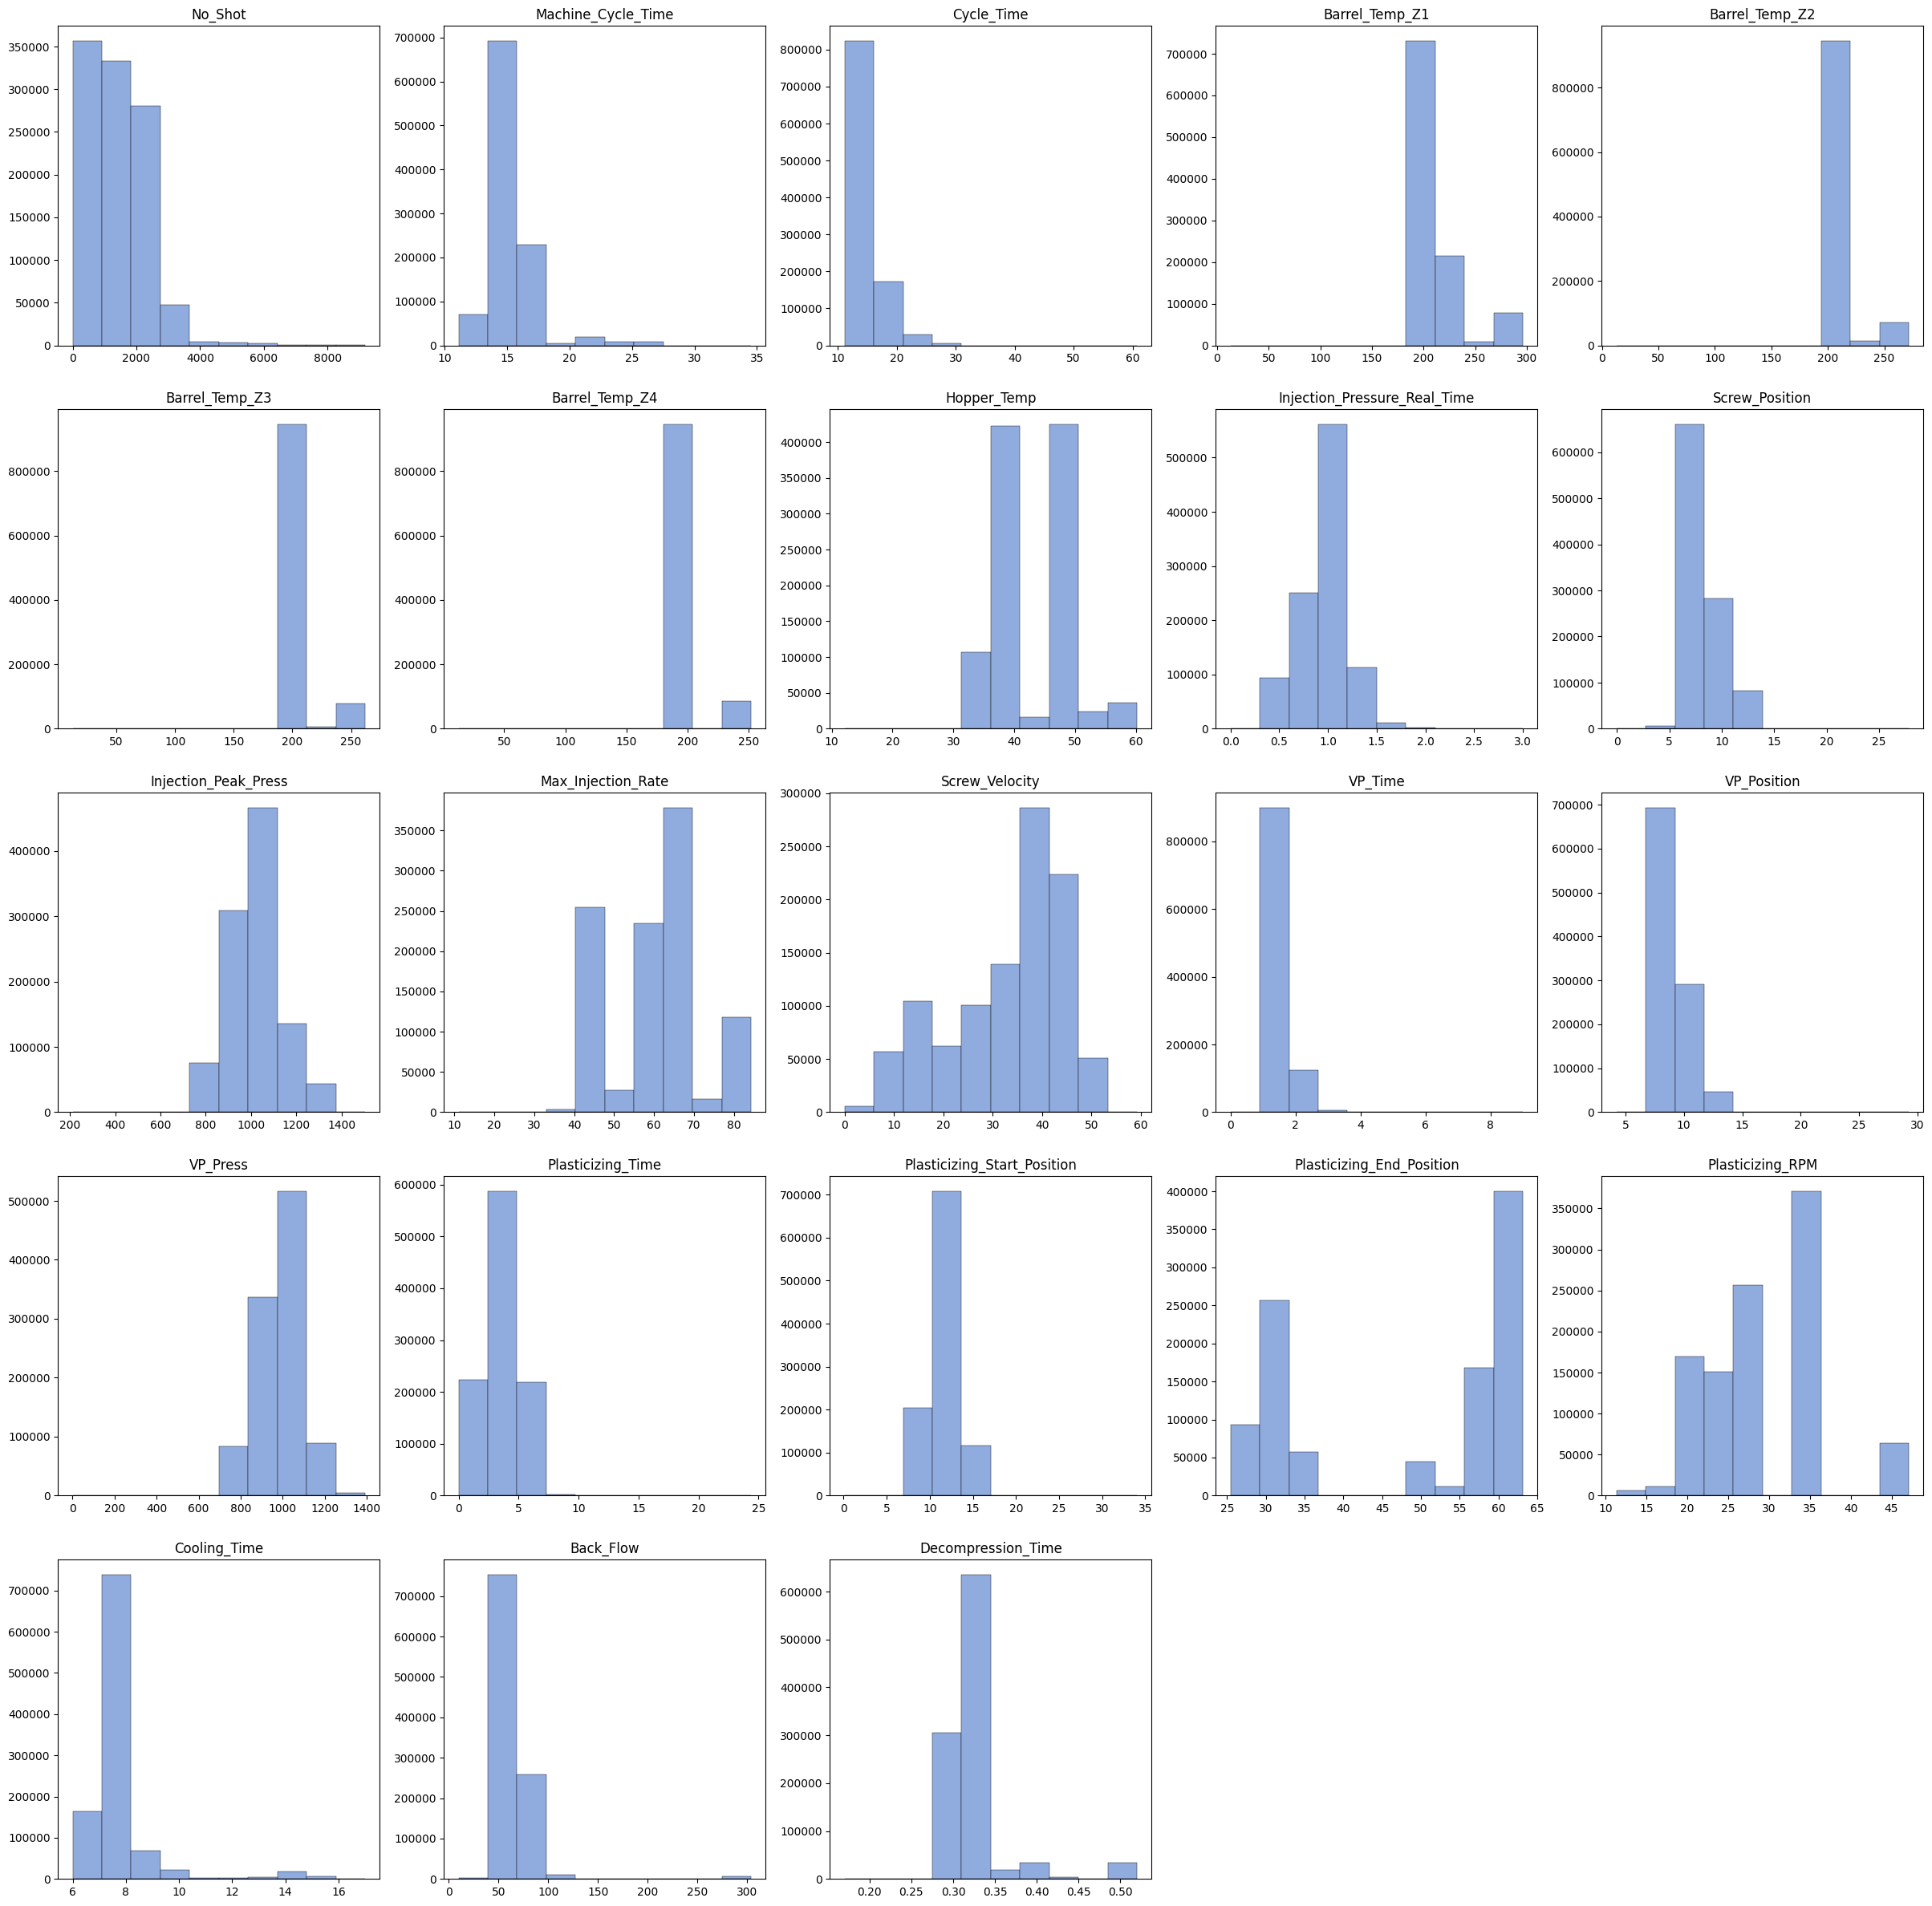

In [ ]:
# 히스토그램 시각화
plt.figure(figsize=(30,30))
for index, value in enumerate(data_drop):
    sub = plt.subplot(5,5,index+1)
    sub.hist(data_drop[value], facecolor = (144/255,171/255,221/255), linewidth=.3, edgecolor='black')
    plt.title(value)

<Axes: >

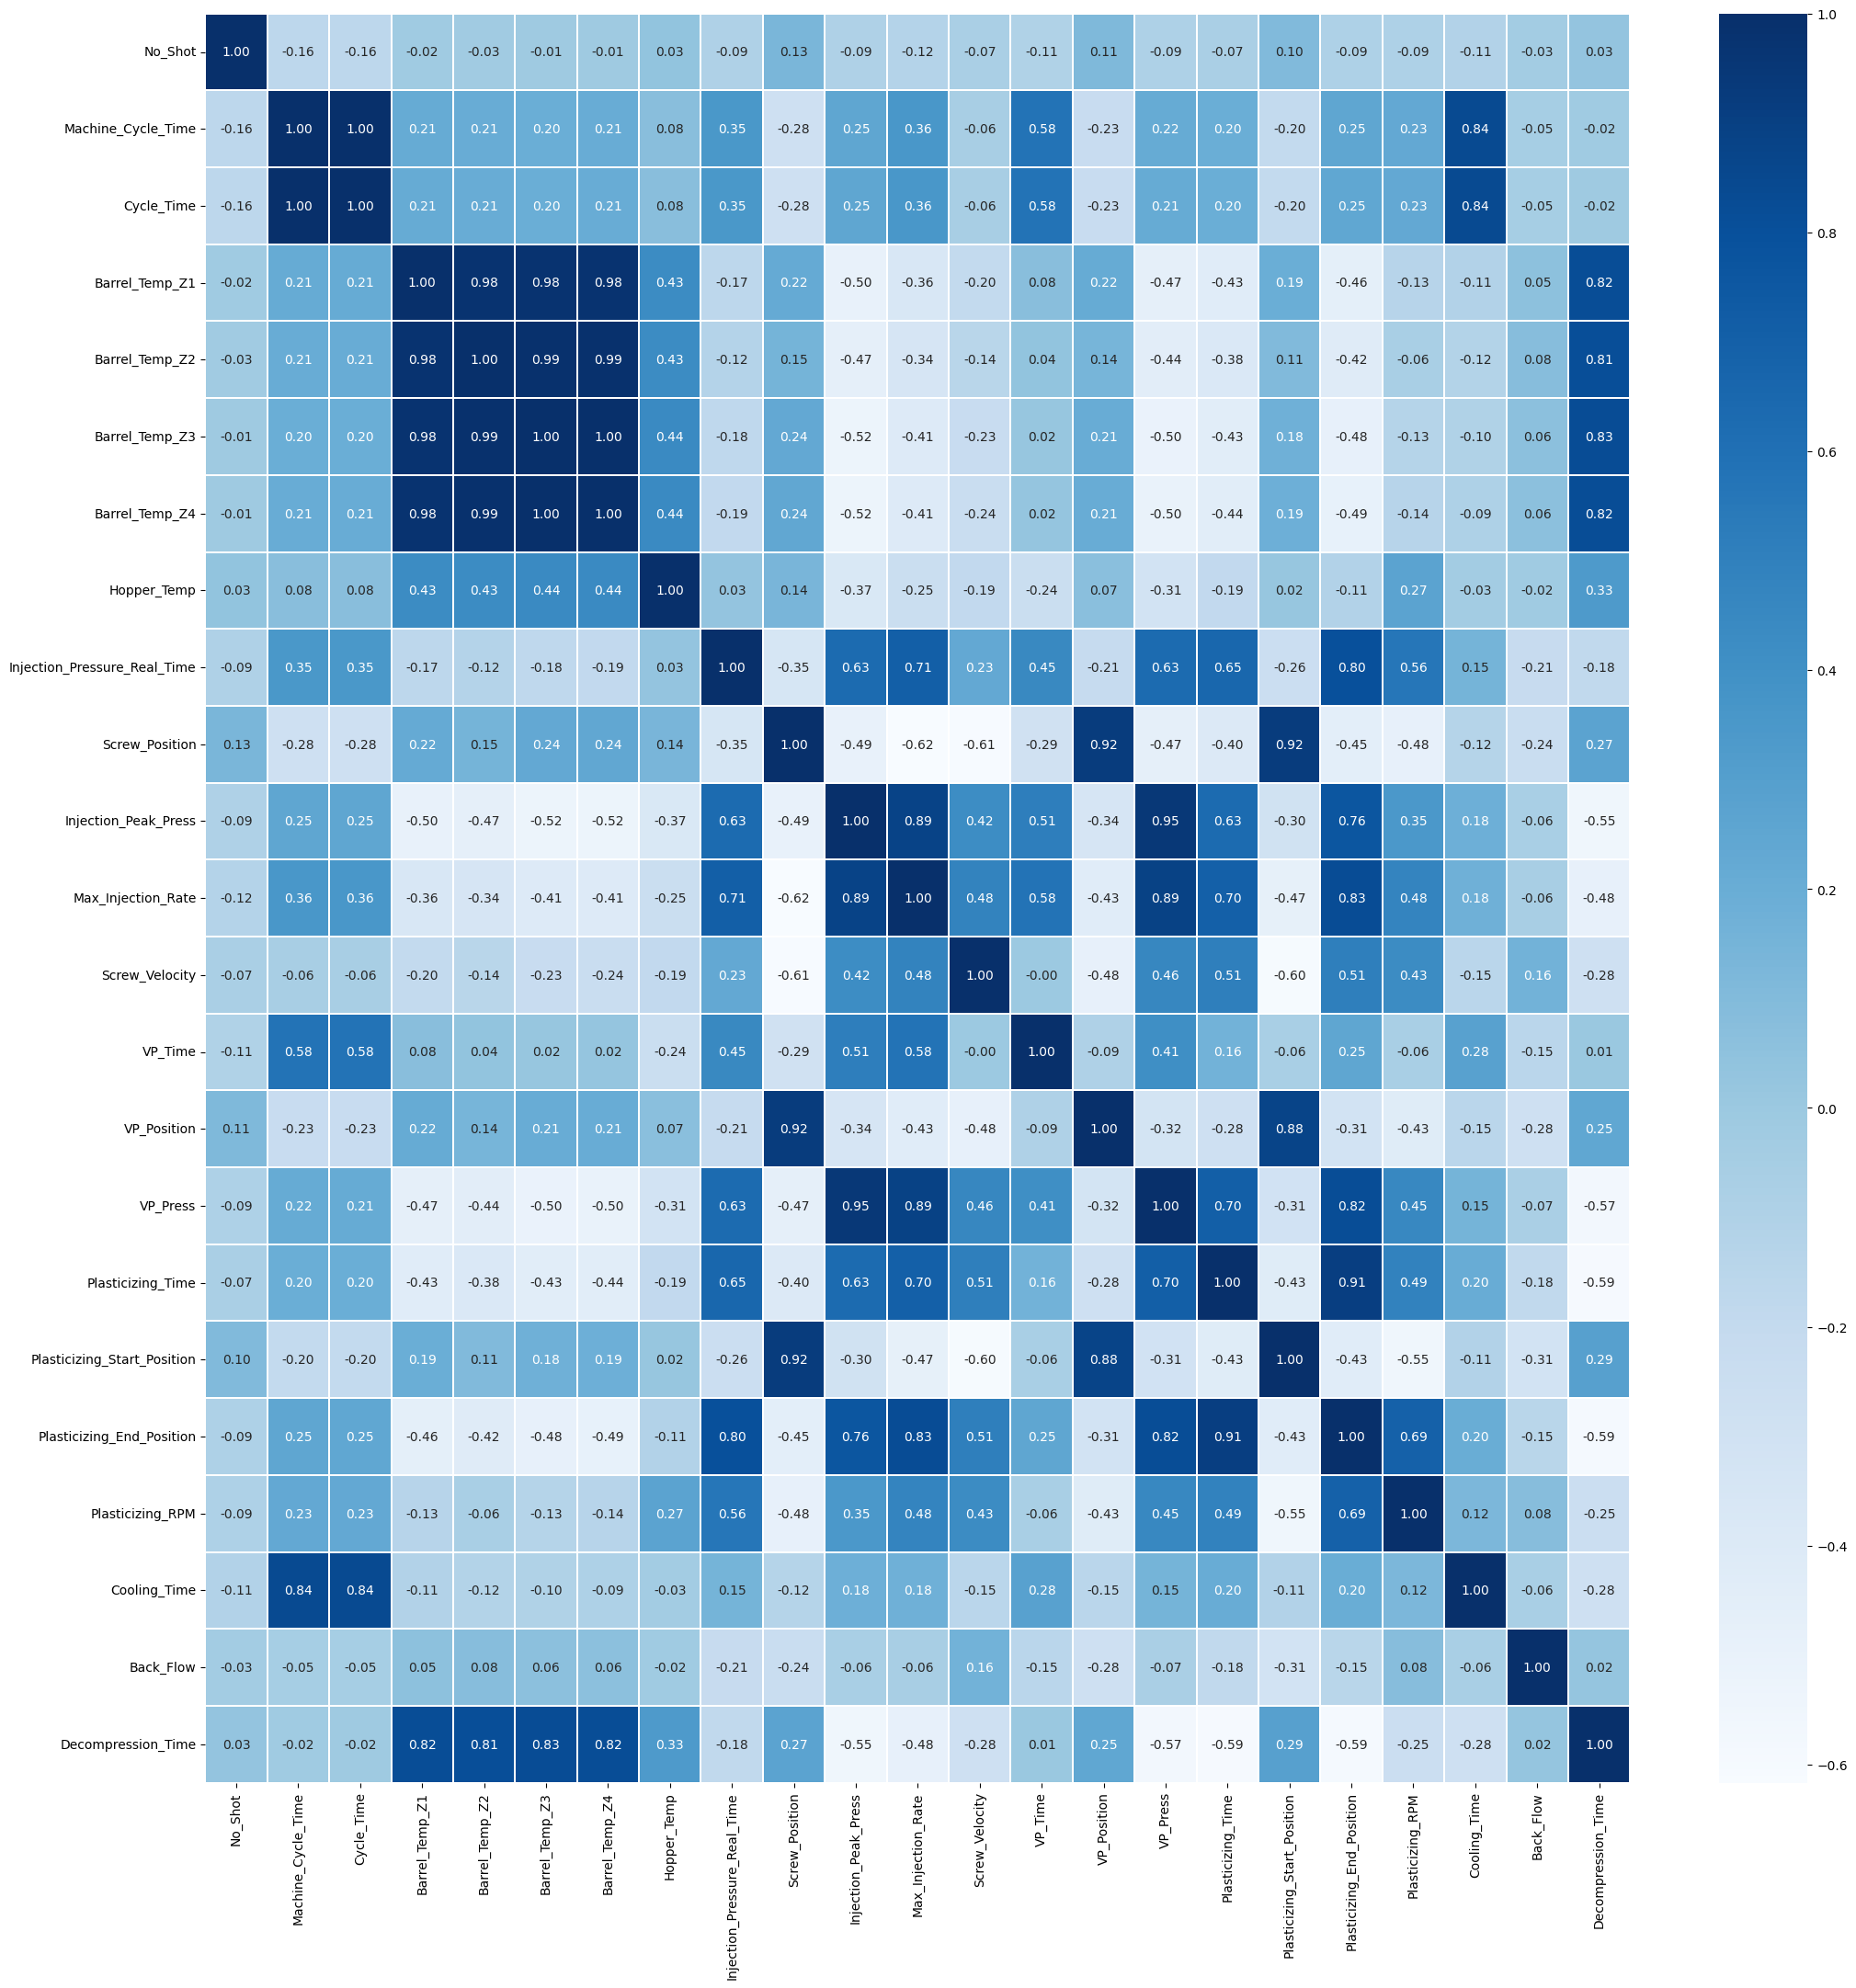

In [ ]:
# 상관계수 시각화
plt.subplots(figsize=(25,25))
sns.heatmap(data = data_drop.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 평균으로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].mean())
lot_mean = pd.DataFrame(data_list).drop(['No_Shot'], axis=1)

In [ ]:
lot_mean.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.668679,16.681723,209.998316,200.042358,194.962824,189.962435,40.085622,1.367863,6.535635,1259.353666,...,2.0,8.119780,1184.873031,4.797461,11.008510,63.111632,28.27,8.0,49.03,0.322306
1,16.660866,16.677780,209.999803,200.038804,195.007241,190.018890,40.089532,1.363695,6.509563,1270.757599,...,2.0,8.119437,1161.965710,4.789536,11.000386,63.111625,28.27,8.0,49.03,0.321893
2,16.681288,16.699753,209.996035,200.036514,195.001296,190.016765,40.078406,1.382933,6.640133,1252.482285,...,2.0,8.121991,1184.553149,4.684229,11.087640,63.111457,28.27,8.0,49.03,0.321735
3,16.634533,16.653553,209.998039,200.040196,195.001059,190.008471,40.090627,1.338847,6.524275,1244.939608,...,2.0,8.123667,1113.798486,4.731149,11.006322,63.111573,28.27,8.0,49.03,0.321718
4,16.610939,16.624291,209.996946,200.031504,195.009702,190.020371,40.125474,1.308349,6.465195,1239.340870,...,2.0,8.124291,1109.827781,4.630274,10.976884,63.111736,28.27,8.0,49.03,0.321701


In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 중앙값으로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].median())
lot_median = pd.DataFrame(data_list).drop(['No_Shot'], axis=1)

In [ ]:
lot_median.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.68,16.68,210.0,200.1,195.0,190.0,40.1,1.38,6.53,1257.17,...,2.0,8.12,1186.15,4.79,11.01,63.11,28.27,8.0,49.03,0.32
1,16.66,16.68,210.0,200.0,195.0,190.0,40.1,1.37,6.51,1272.76,...,2.0,8.12,1161.52,4.79,11.01,63.11,28.27,8.0,49.03,0.32
2,16.70,16.70,210.0,200.0,195.0,190.0,40.1,1.39,6.65,1245.58,...,2.0,8.12,1196.07,4.72,11.08,63.11,28.27,8.0,49.03,0.32
3,16.64,16.66,210.0,200.0,195.0,190.0,40.1,1.34,6.53,1241.34,...,2.0,8.12,1112.63,4.74,11.01,63.11,28.27,8.0,49.03,0.32
4,16.62,16.62,210.0,200.0,195.0,190.0,40.1,1.31,6.47,1231.23,...,2.0,8.12,1111.26,4.63,10.98,63.11,28.27,8.0,49.03,0.32


In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 3분위수로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.75))
lot_75 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

In [ ]:
lot_75.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.68,16.70,210.0,200.1,195.1,190.1,40.2,1.39,6.58,1272.2925,...,2.0,8.13,1201.43,4.82,11.050,63.11,28.27,8.0,49.03,0.32
1,16.68,16.70,210.0,200.1,195.1,190.1,40.2,1.38,6.56,1284.7400,...,2.0,8.13,1178.11,4.82,11.050,63.11,28.27,8.0,49.03,0.32
2,16.70,16.72,210.0,200.1,195.1,190.1,40.2,1.40,6.71,1263.9100,...,2.0,8.13,1223.25,4.77,11.145,63.11,28.27,8.0,49.03,0.32
3,16.66,16.66,210.0,200.1,195.1,190.1,40.2,1.35,6.57,1257.4200,...,2.0,8.13,1123.48,4.77,11.050,63.11,28.27,8.0,49.03,0.32
4,16.62,16.64,210.0,200.1,195.1,190.1,40.2,1.31,6.52,1255.4300,...,2.0,8.13,1125.98,4.65,11.030,63.11,28.27,8.0,49.03,0.32


In [ ]:
# Lot별 대표값 데이터프레임
# 대표값은 1분위수로
data_list = []
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.25))
lot_25 = pd.DataFrame(data_list).drop(['No_Shot'], axis=1).reset_index(drop=True)

In [ ]:
lot_25.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.66,16.66,210.0,200.0,194.9,189.9,40.0,1.35,6.50,1245.58,...,2.0,8.11,1169.25,4.76,10.97,63.11,28.27,8.0,49.03,0.32
1,16.64,16.66,210.0,200.0,194.9,189.9,40.0,1.35,6.47,1258.92,...,2.0,8.11,1148.05,4.76,10.96,63.11,28.27,8.0,49.03,0.32
2,16.66,16.68,210.0,200.0,194.9,189.9,40.0,1.37,6.56,1237.84,...,2.0,8.11,1156.91,4.59,11.02,63.11,28.27,8.0,49.03,0.32
3,16.64,16.64,210.0,200.0,194.9,189.9,40.0,1.33,6.49,1227.40,...,2.0,8.11,1103.03,4.70,10.96,63.11,28.27,8.0,49.03,0.32
4,16.60,16.62,210.0,200.0,194.9,190.0,40.0,1.30,6.41,1221.13,...,2.0,8.12,1094.42,4.60,10.92,63.11,28.27,8.0,49.03,0.32


In [ ]:
# IQR을 통한 이상치 분류 함수
def outliers_iqr(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    return np.where((data>upper_bound)|(data<lower_bound))

In [ ]:
# Lot별 대표값을 통한 abnormal 탐색 함수
# 각 컬럼별 이상치가 4개 이상인 Lot 번호(index)를 abnormal이라 판단
def outlier_search(lot_rep):
    rep_index = []
    for i in range(lot_rep.shape[1]):
        rep_index.append(outliers_iqr(lot_rep[lot_rep.columns[i]])[0])
    a = 0
    outlier_index = []
    for i in range(len(lot_rep)):
        a = 0
        for j in rep_index:
            if i in j:
                a = a + 1
        if a > 3:
            outlier_index.append(i)
    return outlier_index

In [ ]:
# 각 대표값 별 abnormal 합집합
IQR_error=sorted((list(set(outlier_search(lot_mean)+outlier_search(lot_median)+outlier_search(lot_75)+outlier_search(lot_25)))))

In [ ]:
print(IQR_error)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]


In [ ]:
# x: 독립변인들의value값만추출
# y: 종속변인추출
x = lot_mean.drop(['Machine_Cycle_Time'], axis=1).values
y = lot_mean['Machine_Cycle_Time'].values

In [ ]:
# x객체에 x를 표준화한 데이터를 저장
x = MinMaxScaler().fit_transform(x)

In [ ]:
# 2개의 주성분(n_components)으로 이루어진 데이터프레임 구성
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

In [ ]:
principalDf.head()

,principal component1,principal component2
0,-0.873603,0.343205
1,-0.865574,0.340311
2,-0.837708,0.320043
3,-0.785490,0.296093
4,-0.766725,0.286019


In [ ]:
# epsilon, 최소 샘플 개수 설정
# 모델을 DBSCAN 알고리즘 사용
a = 0.165
b = 10
model = DBSCAN(eps=a, min_samples=b)

In [ ]:
# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(principalDf)
principalDf['cluster'] = model.fit_predict(principalDf)

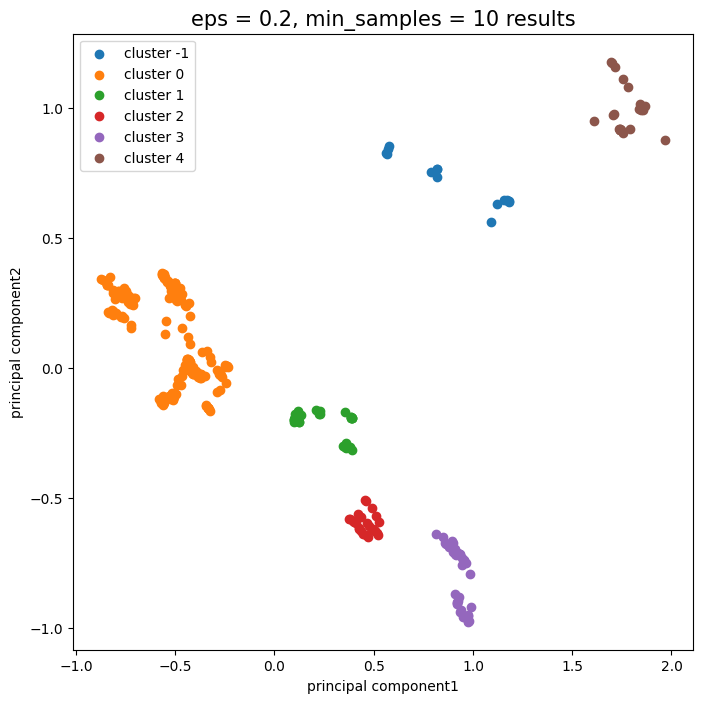

In [ ]:
# matplotlib 라이브러리를 통한 군집 시각화
# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
plt.figure(figsize=(8,8))
for i in range(-1, principalDf['cluster'].max() + 1):
    plt.scatter(principalDf.loc[principalDf['cluster'] == i, 'principal component1'],
                principalDf.loc[principalDf['cluster'] == i, 'principal component2'],
                label = 'cluster ' + str(i))
plt.legend()
plt.title('eps = %.1f, min_samples = %d results'%(a, b), size=15)
plt.xlabel('principal component1', size=10)
plt.ylabel('principal component2', size=10)
plt.show()

In [ ]:
# DBSCAN 군집화를 통해 발견한 abnormal 예상 Lot 분류
DB_error=[]
for i in range(len(principalDf)):
    if principalDf['cluster'][i]==4:
        DB_error.append(i)
    elif principalDf['cluster'][i]==-1:
        DB_error.append(i)

In [ ]:
# IQR을 통한 abnormal Lot 번호와 DBSCAN을 통한 abnormal Lot 번호의 합집합
# 총 43개의 Lot을 abnormal이라 판단
error_list = sorted(list(set(IQR_error + DB_error)))
print('abnormal Lot 번호:', error_list)
print('abnormal Lot 개수:', len(error_list))

abnormal Lot 번호: [85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]
abnormal Lot 개수: 43


In [ ]:
# Shot 데이터에 Lot 번호 라벨링
n_Lot_list = []
for i in range(len(data_n_lot)):
    a = i
    Lot_label = data_n_lot[i].copy()
    Lot_label.loc[:,['Lot']] = a
    n_Lot_list.append(Lot_label)

<ipython-input-41-b7d84d6b25b9>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
<ipython-input-41-b7d84d6b25b9>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['Lot']] = a
<ipython-input-41-b7d84d6b25b9>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Lot_label.loc[:,['

In [ ]:
# concat 함수를 통한 데이터 결합
data_lot_label = n_Lot_list[0]
for i in range(len(n_Lot_list)):
    if i == 0:
        pass
    else:
        data_lot_label = pd.concat([data_lot_label, n_Lot_list[i]])
data_lot_label = data_lot_label.reset_index(drop=True)

In [ ]:
# abnormal shot 라벨링
data_lot_label.loc[:, ['PassOrFail']] = 0
for i in range(len(data_lot_label)):
    if data_lot_label['Lot'][i] in error_list:
        data_lot_label.loc[i,['PassOrFail']] = 1
data_shot_label = data_lot_label.copy().drop(['No_Shot'],axis=1)

<ipython-input-43-b0b5c9528e13>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_lot_label.loc[:, ['PassOrFail']] = 0


In [ ]:
# 라벨링 갯수 비교
data_shot_label['PassOrFail'].value_counts()

0    935814
1     94600
Name: PassOrFail, dtype: int64

In [ ]:
data_shot_label = data_shot_label.copy().drop(['Lot'],axis=1)

In [ ]:
# Lot별 평균 데이터 스케일링
scaler = MinMaxScaler()
df_sum_drop_scaler = scaler.fit_transform(data_shot_label)
df_sum_drop_scaler = pd.DataFrame(df_sum_drop_scaler)

In [ ]:
# normal shot
df_Y_scaler = df_sum_drop_scaler[df_sum_drop_scaler[22]==0]
print('normal shot:', len(df_Y_scaler))
# abnormal shot
df_N_scaler = df_sum_drop_scaler[df_sum_drop_scaler[22]==1]
print('abnormal shot:', len(df_N_scaler))

normal shot: 935814
abnormal shot: 94600


In [ ]:
# ‘PassOrFail’ 변수 제거
df_Y_scaler = df_Y_scaler.drop(columns=[22])
df_N_scaler = df_N_scaler.drop(columns=[22])

In [ ]:
# 학습 데이터, 평가데이터(normal shot)
Y_train, Y_test = train_test_split(df_Y_scaler, test_size = 0.3, random_state = 1234)
# 평가 데이터(abnromal shot)
N_test = df_N_scaler
print('normal 학습 데이터셋 개수:', len(Y_train))
print('normal 평가 데이터셋 개수:', len(Y_test))
print('abnormal 평가 데이터셋 개수:', len(N_test))

normal 학습 데이터셋 개수: 655069
normal 평가 데이터셋 개수: 280745
abnormal 평가 데이터셋 개수: 94600


In [ ]:
# 인코더
dropout_encoder = Sequential([
    Dropout(0.3),
    Dense(15, activation="relu"), # 첫 번째 은닉층
    Dense(5, activation="relu") # 두 번째 은닉층
])
# 디코더
dropout_decoder = Sequential([
    Dense(15, activation="relu", input_shape=[5]), # 세 번째 은닉층
    Dense(Y_train.shape[1], activation='relu'), # 출력
])
dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [ ]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# 모델 훈련
history = dropout_AE.fit(Y_train, Y_train, batch_size=30, epochs=30, validation_split=0.2,
                         callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

Epoch 1/30
17469/17469 [==============================] - 83s 4ms/step - loss: 0.0227 - accuracy: 0.7384 - val_loss: 0.0283 - val_accuracy: 0.1750
Epoch 2/30
17469/17469 [==============================] - 72s 4ms/step - loss: 0.0219 - accuracy: 0.7631 - val_loss: 0.0290 - val_accuracy: 0.1810
Epoch 3/30
17469/17469 [==============================] - 74s 4ms/step - loss: 0.0219 - accuracy: 0.7659 - val_loss: 0.0280 - val_accuracy: 0.3107
Epoch 4/30
17469/17469 [==============================] - 71s 4ms/step - loss: 0.0145 - accuracy: 0.7711 - val_loss: 0.0057 - val_accuracy: 0.3231
Epoch 5/30
17469/17469 [==============================] - 71s 4ms/step - loss: 0.0025 - accuracy: 0.7705 - val_loss: 0.0039 - val_accuracy: 0.7113
Epoch 6/30
17469/17469 [==============================] - 73s 4ms/step - loss: 0.0025 - accuracy: 0.7711 - val_loss: 0.0055 - val_accuracy: 0.3885
Epoch 7/30
17469/17469 [==============================] - 72s 4ms/step - loss: 0.0025 - accuracy: 0.7696 - val_loss: 0

In [ ]:
# 학습 데이터의 예측값
train_pred = dropout_AE.predict(Y_train)
# 학습 데이터의 복원 오차 (예측값 실제값)
train_loss = np.mean(np.square(train_pred-Y_train),axis=1)
# 임계치
threshold = np.mean(train_loss) + 5*np.std(train_loss)
print("복원 오류 임계치:", threshold)

20471/20471 [==============================] - 36s 2ms/step
복원 오류 임계치: 0.028298007847725005


In [ ]:
# 예측값
predict_Y = dropout_AE.predict(Y_test)
# normal 평가 데이터의 복원 오차 (예측값 실제값)
test_Y_mse = np.mean(np.square(predict_Y - Y_test),axis=1)
# normal로 판단한 데이터 확인
test_Y_anomalies = test_Y_mse > threshold
print("normal로 판단한 데이터 확인:\n", test_Y_anomalies)

8774/8774 [==============================] - 15s 2ms/step
normal로 판단한 데이터 확인:
 771963    False
385641    False
394656    False
222221    False
436195    False
          ...  
860980    False
383067    False
229916    False
668705    False
255661    False
Length: 280745, dtype: bool


In [ ]:
# 예측값
predict_N = dropout_AE.predict(df_N_scaler)
# abnormal 평가 데이터의 복원 오차 (예측값 실제값)
test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
# abnormal로 판단한 데이터 확인
test_N_anomalies = test_N_mse > threshold
print("abnormal로 판단한 데이터 확인:\n", test_N_anomalies)

2957/2957 [==============================] - 12s 4ms/step
abnormal로 판단한 데이터 확인:
 210410     True
210411     True
210412     True
210413     True
210414     True
           ... 
1030409    True
1030410    True
1030411    True
1030412    True
1030413    True
Length: 94600, dtype: bool


In [ ]:
true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
accuracy = np.round(accuracy_score(true,prediction), 4)
recall = np.round(recall_score(true,prediction,pos_label=0), 4)
precision = np.round(precision_score(true,prediction,pos_label=0), 4)
f1_score = np.round((2*recall*precision/(recall+precision)), 4)
print(confusion_matrix(true,prediction))
print('정확도:', accuracy)
print('재현율:', recall)
print('정밀도:', precision)
print('f1-score', f1_score)

[[280641    104]
 [     0  94600]]
정확도: 0.9997
재현율: 0.9996
정밀도: 1.0
f1-score 0.9998


In [ ]:
# 노드 22, 11 drop out = 0.3, patience = 8, threshold = 1.5
# 정확도 정밀도가 높아지고, 혼동행렬을 통해 abnormal과 normal을 고루 잡아낼 수 있는것을 확인
# 인코더
dropout_encoder=Sequential([
    Dropout(0.3),
    Dense(22, activation="relu"), # 첫 번째 은닉층
    Dense(11, activation="relu") # 두 번째 은닉층
])
# 디코더
dropout_decoder=Sequential([
    Dense(22, activation="relu", input_shape=[11]), # 세 번째 은닉층
    Dense(Y_train.shape[1], activation='relu'), # 출력
])
dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [ ]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
# 모델 훈련
history = dropout_AE.fit(Y_train, Y_train, batch_size=30, epochs=30, validation_split=0.2,
                         callbacks=[EarlyStopping(monitor="val_loss", patience=8, mode="min")])

Epoch 1/30
17469/17469 [==============================] - 76s 4ms/step - loss: 0.0179 - accuracy: 0.7202 - val_loss: 0.0084 - val_accuracy: 0.2730
Epoch 2/30
17469/17469 [==============================] - 72s 4ms/step - loss: 0.0015 - accuracy: 0.8127 - val_loss: 0.0081 - val_accuracy: 0.3453
Epoch 3/30
17469/17469 [==============================] - 74s 4ms/step - loss: 0.0015 - accuracy: 0.8171 - val_loss: 0.0086 - val_accuracy: 0.2832
Epoch 4/30
17469/17469 [==============================] - 72s 4ms/step - loss: 0.0014 - accuracy: 0.8234 - val_loss: 0.0074 - val_accuracy: 0.2917
Epoch 5/30
17469/17469 [==============================] - 73s 4ms/step - loss: 0.0014 - accuracy: 0.8261 - val_loss: 0.0107 - val_accuracy: 0.2409
Epoch 6/30
17469/17469 [==============================] - 74s 4ms/step - loss: 0.0014 - accuracy: 0.8248 - val_loss: 0.0100 - val_accuracy: 0.2174
Epoch 7/30
17469/17469 [==============================] - 73s 4ms/step - loss: 0.0015 - accuracy: 0.8348 - val_loss: 0

In [ ]:
# 학습 데이터의 예측값
train_pred = dropout_AE.predict(Y_train)
# 학습 데이터의 복원 오차 (예측값 실제값)
train_loss = np.mean(np.square(train_pred-Y_train), axis=1)
# 임계치
threshold = np.mean(train_loss) + 1.5*np.std(train_loss)
print("복원 오류 임계치:", threshold)

20471/20471 [==============================] - 35s 2ms/step
복원 오류 임계치: 0.02217286804811204


In [ ]:
# 예측값
predict_Y = dropout_AE.predict(Y_test)
# normal 평가 데이터의 복원 오차 (예측값 실제값)
test_Y_mse = np.mean(np.square(predict_Y, Y_test), axis=1)
# normal로 판단한 데이터 확인
test_Y_anomalies = test_Y_mse > threshold
print("normal로 판단한 데이터 확인:\n", test_Y_anomalies)

8774/8774 [==============================] - 21s 2ms/step
normal로 판단한 데이터 확인:
 771963    True
385641    True
394656    True
222221    True
436195    True
          ... 
860980    True
383067    True
229916    True
668705    True
255661    True
Length: 280745, dtype: bool


In [ ]:
# 예측값
predict_N = dropout_AE.predict(df_N_scaler)
# abnormal 평가 데이터의 복원 오차 (예측값 실제값)
test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
# abnormal로 판단한 데이터 확인
test_N_anomalies = test_N_mse > threshold
print("abnormal로 판단한 데이터 확인:\n", test_N_anomalies)

2957/2957 [==============================] - 5s 2ms/step
abnormal로 판단한 데이터 확인:
 210410     True
210411     True
210412     True
210413     True
210414     True
           ... 
1030409    True
1030410    True
1030411    True
1030412    True
1030413    True
Length: 94600, dtype: bool


In [ ]:
true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])
accuracy = np.round(accuracy_score(true,prediction), 4)
recall = np.round(recall_score(true,prediction,pos_label=0), 4)
precision = np.round(precision_score(true,prediction,pos_label=0), 4)
f1_score = np.round((2*recall*precision/(recall+precision)), 4)
print(confusion_matrix(true,prediction))
print('정확도:', accuracy)
print('재현율:', recall)
print('정밀도:', precision)
print('f1-score', f1_score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-64-5d5f63e56373>:6: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.round((2*recall*precision/(recall+precision)), 4)


[[     0 280745]
 [     0  94600]]
정확도: 0.252
재현율: 0.0
정밀도: 0.0
f1-score nan


In [ ]:
# 파라미터가 조절된 모델을 교차검증 하기 위해 k-fold validation사용
kf = KFold(n_splits = 5, shuffle = True, random_state = 1234)
dropout_AE.compile(loss="mse", optimizer=Adam(lr=0.01), metrics=['accuracy'])
cv_confusion_matrix = np.array([[0,0],[0,0]])
cv_accuracy = []
cv_recall = []
cv_precision = []
cv_f1_score = []
n_iter = 0

In [ ]:
for train_index, test_index in kf.split(np.array(df_Y_scaler)):
    X_train, X_test = np.array(df_Y_scaler)[train_index], np.array(df_Y_scaler)[test_index]

    history = dropout_AE.fit(X_train, X_train, batch_size=30, epochs=30, validation_split=0.2,
                            callbacks=[EarlyStopping(monitor="val_loss", patience=8, mode="min")])

    n_iter += 1

    # 학습 데이터의 예측값
    train_pred = dropout_AE.predict(X_train)
    # 학습 데이터의 복원 오차 (예측값 실제값)
    train_loss = np.mean(np.square(train_pred, X_train), axis=1)
    # 임계치
    threshold = np.mean(train_loss) + 1.5*np.std(train_loss)

    # 예측값
    predict_Y = dropout_AE.predict(X_test)
    # narmal 평가 데이터의 복원 오차 (예측값 실제값)
    test_Y_mse = np.mean(np.square(predict_Y-X_test), axis=1)
    # abnormal로 판단한 데이터 확인
    test_Y_anomalies = test_Y_mse > threshold

    # 예측값
    predict_N = dropout_AE.predict(df_N_scaler)
    # abnormal 평가 데이터의 복원 오차 (예측값 실제값)
    test_N_mse = np.mean(np.square(predict_N, df_N_scaler), axis=1)
    # abnormal로 판단한 데이터 확인
    test_N_anomalies = test_N_mse > threshold

    true = np.concatenate([np.zeros(len(test_Y_anomalies)), np.ones(len(test_N_anomalies))])
    prediction = np.concatenate([test_Y_anomalies, test_N_anomalies])

    accuracy = np.round(accuracy_score(true, prediction), 4)
    recall = np.round(recall_score(true, prediction, pos_label=0), 4)
    precision = np.round(precision_score(true, prediction, pos_label = 0), 4)
    f1_score = np.round((2*recall*precision/(recall+precision)), 4)
    cv_confusion_matrix = cv_confusion_matrix + confusion_matrix(true, prediction)
    cv_accuracy.append(accuracy)
    cv_recall.append(recall)
    cv_precision.append(precision)
    cv_f1_score.append(f1_score)

    print('\n회차:', n_iter)
    print(confusion_matrix(true, prediction))
    print('정확도:', accuracy)
    print('재현율:', recall)
    print('정밀도:', precision)
    print('f1-score:', f1_score)
    print('\n')

Epoch 1/30
19964/19964 [==============================] - 76s 4ms/step - loss: 0.0011 - accuracy: 0.8637 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 2/30
19964/19964 [==============================] - 74s 4ms/step - loss: 0.0010 - accuracy: 0.8631 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 3/30
19964/19964 [==============================] - 82s 4ms/step - loss: 0.0010 - accuracy: 0.8610 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 4/30
19964/19964 [==============================] - 72s 4ms/step - loss: 0.0010 - accuracy: 0.8599 - val_loss: 0.0166 - val_accuracy: 0.0000e+00
Epoch 5/30
19964/19964 [==============================] - 72s 4ms/step - loss: 0.0010 - accuracy: 0.8587 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 6/30
19964/19964 [==============================] - 73s 4ms/step - loss: 0.0010 - accuracy: 0.8568 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 7/30
19964/19964 [==============================] - 71s 4ms/step - loss: 0.0010 - accura

In [ ]:
# 평균 결과값 확인
print('k-fold 평균 결과')
print((cv_confusion_matrix/5).round())
print('평균 정확도:', round(np.mean(cv_accuracy), 4))
print('평균 재현율:', round(np.mean(cv_recall), 4))
print('평균 정밀도:', round(np.mean(cv_precision), 4))
print('평균 f1-score:', round(np.mean(cv_f1_score), 4))